In [14]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from tqdm import tqdm

import boda
#from boda.generator.parameters import StraightThroughParameters
#from boda.generator import FastSeqProp
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

In [2]:
def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    for motif_idx in range(len(motif_dict)):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()
        
def fasta_to_input_tensor(file_name, left_flank, right_flank):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    sequences = torch.stack(seq_tensors, dim=0)
    pieces = [left_flank.repeat(sequences.shape[0], 1, 1), sequences,  right_flank.repeat(sequences.shape[0], 1, 1)]
    return torch.cat(pieces, axis=-1)

def plot3D_activities(activities_tensor, color='blue', fig_size=(15, 10), alpha=0.2, ax_lims=(-2, 8)):
    xdata = activities_tensor[:,0].cpu().detach().numpy()
    ydata = activities_tensor[:,1].cpu().detach().numpy()
    zdata = activities_tensor[:,2].cpu().detach().numpy()

    fig = plt.figure(figsize=fig_size)
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    xAxisLine = (ax_lims, (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), ax_lims, (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), ax_lims)
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
    dAxisLine = (ax_lims, ax_lims, ax_lims)
    ax.plot(dAxisLine[0], dAxisLine[1], dAxisLine[2], 'gray', linestyle='dashed')

    ax.scatter3D(xdata, ydata, zdata, c=color, alpha=alpha)
    ax.set_xlabel('K562')
    ax.set_ylabel('HepG2')
    ax.set_zlabel('SKNSH')
    ax.view_init(15, -45)
    
def unpickle_logs(log_path):
    log_df = pd.read_pickle(log_path + 'sequence_data.pkl')
    with open(log_path + 'pmms_list.pkl', 'rb') as fp:
        pmms_list = pickle.load(fp)
    return log_df, pmms_list

In [3]:
#----------------------- HPO model -----------------------
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
hpo_model = model_fn(model_dir)
hpo_model.eval()

Loaded model from 20211110_194934 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [32]:
#----------------------- Artisanal model -----------------------
# ! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1.ckpt ./
# ! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1_ReLU6_sneak2_double1_ACGT_gtex_noNorm_lessVal_activity_1_4.ckpt ./
! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_lasthidden250_ReLU_sneak2_noSynth_LocusSelect_activity1_4.ckpt ./

activation='ReLU'    
artisan_model = MPRA_Basset(extra_hidden_size = 250,
                            last_activation=activation)
checkpoint = torch.load('manual_checkpoint_lasthidden250_ReLU_sneak2_noSynth_LocusSelect_activity1_4.ckpt')
artisan_model.load_state_dict(checkpoint['state_dict'])
artisan_model.eval()

Copying gs://syrgoth/checkpoints/manual_checkpoint_lasthidden250_ReLU_sneak2_noSynth_LocusSelect_activity1_4_noHD.ckpt...
- [1 files][ 62.0 MiB/ 62.0 MiB]                                                
Operation completed over 1 objects/62.0 MiB.                                     


MPRA_Basset(
  (criterion): MSELoss()
  (last_activation): ReLU()
  (basset_net): Basset(
    (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
    (conv1): Conv1dNorm(
      (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
      (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
    (conv2): Conv1dNorm(
      (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
      (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
    (conv3): Conv1dNorm(
      (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
      (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
    (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (maxpool_4): MaxPool1d(ker

In [5]:
left_flank = boda.common.utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
right_flank = boda.common.utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200] ).unsqueeze(0)

In [6]:
def linexp_reward(x):
    return torch.exp(-x) - x - 1
def basic_reward(x):
    return x

# def k562_score(x):
#     return x[:,0] - torch.mean(x[:,1:], axis=1) 
# def hepg2_score(x):
#     return x[:,1] - torch.mean(x[:, np.r_[0,2]], axis=1)
# def sknsh_score(x):
#     return x[:,2] - torch.mean(x[:,:2], axis=1)

def k562_score(x):
    return -linexp_reward(x[:,0]) + 0.5 * (linexp_reward( x[:,1]) + linexp_reward( x[:,2]))
def hepg2_score(x):
    return -linexp_reward(x[:,1]) + 0.5 * (linexp_reward( x[:,2]) + linexp_reward( x[:,0]))
def sknsh_score(x):
    return -linexp_reward(x[:,2]) + 0.5 * (linexp_reward( x[:,1]) + linexp_reward( x[:,0]))

def k562_specific(x):
    scores = k562_score(x)
    return torch.mean(-scores)
def hepg2_specific(x):
    scores = hepg2_score(x)
    return torch.mean(- scores)
def sknsh_specific(x):
    scores = sknsh_score(x)
    return torch.mean(- scores)

In [25]:
class energy_multipenalty(nn.Module):
    def __init__(self,
                 predictor,
                 loss_fn,
                 ppms=[],
                 score_pct=0,
                 ppms_alphabet=['A', 'C', 'G', 'T'],
                 backgrounds=None,                 
                 a_min=-math.inf,
                 a_max=math.inf):
        super().__init__()
        self.predictor = predictor
        self.loss_fn = loss_fn
        self.score_pct = score_pct
        self.ppms = ppms
        self.ppms_alphabet = ppms_alphabet
        self.a_min = a_min
        self.a_max = a_max
        
        self.num_ppms = len(self.ppms)      
             
        try: self.predictor.eval()
        except: pass
        
        if len(self.ppms) == 0:
            self.penalization_flag = False
            self.backgrounds = backgrounds
            self.filters = None
            self.score_thresholds = None
        else:
            self.penalization_flag = True
            self.max_ppm_len = max([ppm.shape[-1] for ppm in self.ppms])
            if backgrounds is None:
                self.backgrounds = [ 4*[0.25] for i in range(len(self.ppms))]
            self.filters_and_thresholds()
    
    def filters_and_thresholds(self):
        penalty_weight = len(self.ppms)
        pwms = []
        score_thresholds = []
        for ppm, background in zip(self.ppms, self.backgrounds):
            ppm = align_to_alphabet(ppm, in_alphabet=self.ppms_alphabet)
            pwm = ppm_to_pwm(ppm, background) * np.cbrt(penalty_weight)
            max_score = torch.max(pwm, dim=0)[0].sum()
            pwm_rc = reverse_complement(pwm)
            pwms += [pwm, pwm_rc]
            score_thresholds += 2 * [self.score_pct * max_score]
            penalty_weight -= 1 
        filters = [torch.cat([pwm, pwm.new_zeros(pwm.shape[0], self.max_ppm_len - pwm.shape[-1])], dim=1) for pwm in pwms]
        self.register_buffer('filters', torch.stack(filters, dim=0))
        self.register_buffer('score_thresholds', torch.tensor(score_thresholds))
                   
    def motif_penalty(self, x):
        if self.penalization_flag:
            motif_scores = F.conv1d(x, self.filters)
            score_thresholds = torch.ones_like(motif_scores) * self.score_thresholds[None, :, None]
            mask = torch.ge(motif_scores, score_thresholds) 
            masked_scores = torch.masked_select(motif_scores, mask)
            return masked_scores.sum(dim=-1).mean().div(self.num_ppms * x.shape[0])
        else:
            return 0
        
    def forward(self, x):
        motif_penalty = self.motif_penalty(x)
        preds = self.predictor(x).clamp(self.a_min, self.a_max)
        energy = self.loss_fn(preds) + motif_penalty
        return energy
    
class StraightThroughParameters(nn.Module):
        
    def __init__(self,
                 data, 
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 token_dim=-2,
                 cat_axis=-1,
                 n_samples=1,
                 use_affine=True):
        super().__init__()

        self.register_parameter('theta', nn.Parameter(data.detach().clone()))
        self.register_buffer('left_flank', left_flank.detach().clone())
        self.register_buffer('right_flank', right_flank.detach().clone())
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.n_samples = n_samples
        self.use_affine = use_affine
        
        self.num_classes= self.theta.shape[self.token_dim]
        self.n_dims     = len(self.theta.shape)
        self.repeater   = [ 1 for i in range(self.n_dims - 1) ]
        self.batch_size = self.theta.shape[self.batch_dim]

        self.instance_norm = nn.InstanceNorm1d(num_features=self.num_classes, affine=self.use_affine)
        
    @property
    def shape(self):
        return self.get_logits().shape
        
    def get_logits(self):
        my_attr = [ getattr(self, x) for x in ['left_flank', 'theta', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
        
    def get_probs(self):
        logits = self.instance_norm(self.theta)
        return F.softmax(logits, dim=self.token_dim)
        
    def get_sample(self):
        probs = self.get_probs()
        probs_t = torch.transpose(probs, self.token_dim, self.cat_axis)
        sampled_idxs = Categorical( probs_t )
        samples = sampled_idxs.sample( (self.n_samples, ) )
        samples = F.one_hot(samples, num_classes=self.num_classes)
        samples = torch.transpose(samples, self.token_dim, self.cat_axis)
        probs = probs.repeat( self.n_samples, *[1 for i in range(self.n_dims)] )
        samples = samples - probs.detach() + probs
        return samples
        
    def forward(self):
        pieces = []
        
        if self.left_flank is not None:
            pieces.append( self.left_flank.repeat(self.n_samples, self.batch_size, *self.repeater) )
            
        pieces.append( self.get_sample() )
        
        if self.right_flank is not None:
            pieces.append( self.right_flank.repeat(self.n_samples, self.batch_size, *self.repeater) )
            
        return torch.cat( pieces, axis=self.cat_axis ).flatten(0,1)
                
    def reset(self):
        self.theta.data = torch.randn_like( self.theta )
        return None
        
    def rebatch(self, input):
        return input.unflatten(0, (self.n_samples, self.batch_size)).mean(dim=0)
    
    
class FastSeqProp(nn.Module):

    def __init__(self,
                 energy_fn,
                 params
                ):
        super().__init__()
        self.energy_fn = energy_fn
        self.params = params                           

        try: self.energy_fn.eval()
        except: pass
    
    def run(self, n_steps=20, learning_rate=0.5, step_print=10, lr_scheduler=True, create_plot=True):
     
        if lr_scheduler: etaMin = 1e-6
        else: etaMin = learning_rate
        
        optimizer = torch.optim.Adam(self.params.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_steps, eta_min=etaMin)  
        
        energy_hist = []
        pbar = tqdm(range(1, n_steps+1), desc='Steps', position=0, leave=True)
        for step in pbar:
            optimizer.zero_grad()
            sampled_nucleotides = self.params()
            energy = self.energy_fn(sampled_nucleotides)
            #energy = self.params(preds).mean()
            energy.backward()
            optimizer.step()
            scheduler.step()
            energy_hist.append(energy.item())
            if step % step_print == 0:
                pbar.set_postfix({'Loss': energy.item(), 'LR': scheduler.get_last_lr()[0]})
        
        self.energy_hist = energy_hist
        if create_plot:
            plt.plot(self.energy_hist)
            plt.xlabel('Steps')
            vert_label = plt.ylabel('Energy')
            vert_label.set_rotation(90)
            plt.show()

# Recursive-Penalty Generation

In [26]:
def create_new_log_folder_in(super_folder):
    log_idx = 0
    folder_name = 'log_' + str(log_idx)
    while os.path.isdir(super_folder + folder_name):
        log_idx += 1
        folder_name = 'log_' + str(log_idx)
    log_path = super_folder + folder_name 
    os.makedirs(log_path)
    return log_path + '/'

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('')
    print('')
    print(left_spacer + n * marker)
    print(left_spacer + string)
    print(left_spacer + n * marker)
    print('')
    print('')
    
def decor_print(string):
    decor = 15*'-'
    print('')
    print(decor + ' ' + string + ' ' + decor)
    print('')

Steps:   0%|          | 1/300 [00:00<00:33,  8.99it/s]

Files and logs will be saved in run_logs/log_28/


                         ************************************
                         * DESIGNING WITH 0 MOTIF PENALTIES *
                         ************************************




Steps: 100%|██████████| 300/300 [00:29<00:00, 10.07it/s, Loss=-7.56, LR=1e-6]   


Running STREME...


                         *****************
                         * ENTROPY PLOTS *
                         *****************




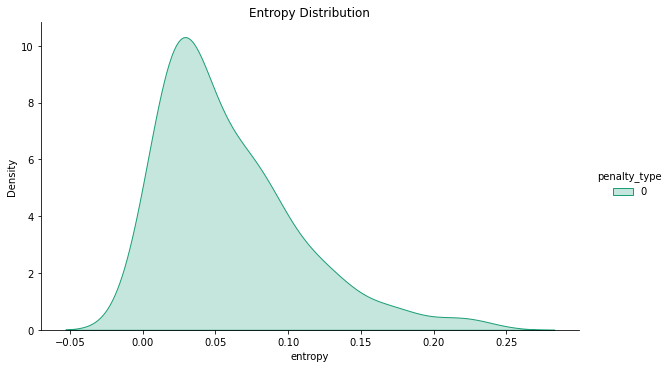

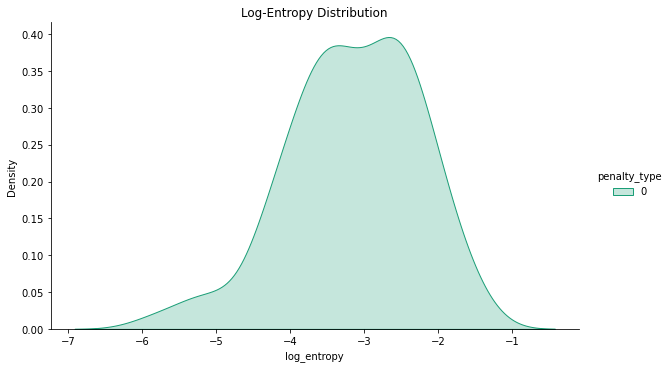



                         ******************
                         * ACTIVITY PLOTS *
                         ******************




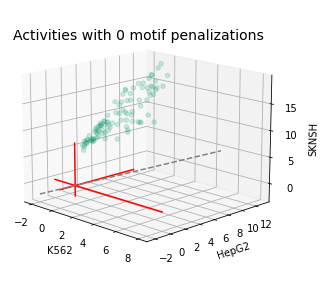



                         *********************************
                         * TOP MOTIF FROM EACH ITERATION *
                         *********************************



--------------- Top motif 0 | Sites: 87 | E-value: 0.0044 ---------------



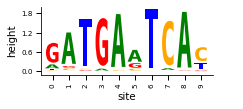

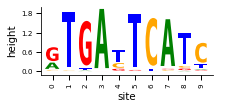

CPU times: user 1min 3s, sys: 1.65 s, total: 1min 5s
Wall time: 1min 6s


In [35]:
%%time

#------------------ Choose settings ------------------
in_line_plots = False

loss_fn = sknsh_specific
model   = artisan_model
penalty_iterations = 0

num_batches = 2
batch_size  = 50 
n_samples  = 20    
num_steps  = 300   
score_pct = 0.0

affine_trans = False
scheduler    = True
loss_plots   = False

settings = {'num_batches': num_batches,
            'batch_size:': batch_size,
            'n_samples': n_samples,
            'num_steps': num_steps,
            'score_pct': score_pct,
            'affine_trans': affine_trans,
            'scheduler': scheduler,
            'loss_fn': str(loss_fn).lstrip('<function ')[:str(loss_fn).lstrip('<function ').find(' at')],
            'model': str(model)[:str(model).find('\n')-1]
           }

streme_results_list = []
ppms_list = []
results_alphabet = ['A', 'C', 'G', 'T']
results_backgrounds = []
top_ppms_summaries = []

log_path = create_new_log_folder_in('run_logs/')
os.makedirs(log_path + '/figures')
figures_path = log_path + '/figures/'
print(f'Files and logs will be saved in {log_path}')

all_distributions = []
all_predictions = []
all_sequences = []
all_entropies = []
for penalty_iteration in range(penalty_iterations + 1):
    frame_print(f'Designing with {penalty_iteration} motif penalties')
    energy = energy_multipenalty(predictor=model,
                                 loss_fn=loss_fn,
                                 ppms=ppms_list,
                                 score_pct=score_pct,
                                 streme_alphabet=results_alphabet,
                                 streme_background=None)
                                 #streme_background=results_backgrounds)    
    distributions = []
    sequence_samples = []
    predictions = []
    entropies = []
    for batch in range(num_batches):
        theta_ini = torch.randn(batch_size, 4, 200)
        params = StraightThroughParameters(data=theta_ini,
                                           left_flank=left_flank,
                                           right_flank=right_flank,
                                           n_samples=n_samples,
                                           use_affine=affine_trans)
        generator = FastSeqProp(energy_fn=energy,
                                params=params)
        generator.cuda()
        generator.run(n_steps=num_steps,
                      learning_rate=0.5,
                      step_print=5,
                      lr_scheduler=scheduler,
                      create_plot=loss_plots)
        samples = params()
        preds = energy.predictor(samples)
        distributions.append(params.get_probs().detach().cpu())    
        sequence_samples.append(samples.detach().cpu().unflatten(0, (n_samples, batch_size)))
        predictions.append(preds.detach().cpu().unflatten(0, (n_samples, batch_size)))
        entropies.append(boda.graph.utils.shannon_entropy(preds).detach().cpu().unflatten(0, (n_samples, batch_size)))
    
    entropy_tensor = torch.cat(entropies, dim=1)
    prediction_tensor = torch.cat(predictions, dim=1)
    sequences_tensor = torch.cat(sequence_samples, dim=1)
    distributions_tensor = torch.cat(distributions, dim=0)
    
    #------------------ Select best sequences ------------------
    best_entropy_idxs = torch.argmin(entropy_tensor, dim=0)
    best_entropies = []
    best_predictions = []
    best_sequences = []
    for idx, best_idx in enumerate(best_entropy_idxs.tolist()):
        best_entropies.append(entropy_tensor[best_idx, idx])
        best_predictions.append(prediction_tensor[best_idx, idx, :])
        best_sequences.append(sequences_tensor[best_idx, idx, :, 200:400])

    best_sequences = torch.stack(best_sequences, dim=0)
    best_entropies = torch.tensor(best_entropies)
    best_predictions = torch.stack(best_predictions, dim=0)
        
    all_distributions.append(distributions_tensor)
    all_sequences.append(best_sequences)
    all_predictions.append(best_predictions)
    all_entropies.append(best_entropies)
    
    #------------------ Plot entropy distribution ------------------
    if in_line_plots:
        sns.displot(data=best_entropies, kind='kde', fill=True, height=5, aspect=10/6)
        plt.xlim(0, 1)
        plt.xlabel('Entropy')
        plt.show()
        
    #------------------ Plot activities in 3D ------------------
        plot3D_activities(best_predictions)

    #------------------ Sanity distribution check ------------------
        decor_print('Plotting a few distributions...')
        for i in range(5):
            distribution = distributions_tensor[i,:,:]
            matrix_to_dms(ppm_to_IC(distribution), y_max=2)
            plt.show()
        
    #------------------ Run STREME & Save fasta files ------------------
    if in_line_plots:
        decor_print('Running STREME...')
    else:
        print('Running STREME...')
    file_name = 'sequences_penalty_' + str(penalty_iteration) + '.txt'
    relative_path = log_path + file_name
    utils.batch2fasta(best_sequences, relative_path)
    
    absolute_path = '/home/ubuntu/boda2/analysis/RC04_FastSeqProp_MotifPenalty/' + relative_path
    streme_results = streme(absolute_path)
    parsed_output = parse_streme_output(streme_results['output'])
   
    streme_results_list.append(parsed_output)
    ppms_list.append(torch.Tensor(parsed_output['motif_results'][0]['ppm']))  
    top_ppms_summaries.append(parsed_output['motif_results'][0]['summary'])
    results_backgrounds.append([parsed_output['meta_data']['frequencies'][nt] for nt in constants.STANDARD_NT])
    
    if in_line_plots:
        show_streme_motifs(parsed_output)

log_df = pd.DataFrame(columns=['sequence', 'predictions', 'entropy', 'parent_distribution', 'penalty_type'])
for penalty_iteration in range(penalty_iterations + 1):
    for sequence_idx in range(all_sequences[penalty_iteration].shape[0]):
        log_df = log_df.append({'sequence': all_sequences[penalty_iteration][sequence_idx].numpy(),
                        'predictions': all_predictions[penalty_iteration][sequence_idx].numpy(),
                        'entropy': float(all_entropies[penalty_iteration][sequence_idx].numpy()),
                        'parent_distribution': all_distributions[penalty_iteration][sequence_idx].numpy(),
                        'penalty_type': penalty_iteration}, ignore_index=True)

#------------------ Saving results and settings ------------------  
log_df.to_pickle(log_path + 'sequence_data.pkl')
with open(log_path + 'top_ppms.pkl', 'wb') as fp:
    pickle.dump(ppms_list, fp)
with open(log_path + 'settings.txt', 'w') as ofile:
    for item in settings.items():
        ofile.write(f'{item[0]}: {item[1]}' + "\n")
with open(log_path + 'top_ppms_summaries.txt', 'w') as ofile:
    for summary in top_ppms_summaries:
        ofile.write(str(summary) + "\n")

palette = 'Dark2'
sns.set_palette(palette)
#------------------ Plot entropy and log-entropy------------------  
frame_print('Entropy Plots')
sns.displot(data=log_df, x='entropy', hue='penalty_type', kind='kde',
            fill=True, height=5, aspect=10/6, palette=palette)
plt.title('Entropy Distribution')
plt.savefig(figures_path + 'entropy_distributions.png', bbox_inches='tight')
plt.show()

log_df['log_entropy'] = np.log(log_df['entropy'])
sns.displot(data=log_df, x='log_entropy', hue='penalty_type', kind='kde',
            fill=True, height=5, aspect=10/6, palette=palette)
plt.title('Log-Entropy Distribution')
plt.savefig(figures_path + 'log_entropy_distributions.png', bbox_inches='tight')
plt.show()

#------------------ Plot activities in 3D ------------------   
frame_print('Activity Plots')
for penalty_idx, predictions in enumerate(all_predictions):
    plot3D_activities(predictions, color='C'+str(penalty_idx), fig_size=(5,5))
    plt.suptitle(f'Activities with {penalty_idx} motif penalizations', size=14, y=.82)
    plt.savefig(figures_path + f'activities_penalty_{penalty_idx}.png', bbox_inches='tight')
    plt.show()
    
#------------------ Show top motifs ------------------  
frame_print('Top motif from each iteration')
for ppm_idx, ppm in enumerate(ppms_list):
    ppm = align_to_alphabet(ppm, in_alphabet=results_alphabet)
    icm = ppm_to_IC(ppm)
    icm_rc = reverse_complement(icm)
    nsites = top_ppms_summaries[ppm_idx]['nsites']
    evalue = top_ppms_summaries[ppm_idx]['E']
    decor_print(f'Top motif {ppm_idx} | Sites: {nsites} | E-value: {evalue}')
    matrix_to_dms(icm, y_max=2)
    plt.savefig(figures_path + f'top_motif_{ppm_idx}.png', bbox_inches='tight')
    plt.show()
    matrix_to_dms(icm_rc, y_max=2)
    plt.savefig(figures_path + f'top_motif_rc_{ppm_idx}.png', bbox_inches='tight')
    plt.show()

In [24]:
generator.energy_fn(params())

tensor(-0.1227, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
params.left_flank.repeat(params.n_samples, params.batch_size, *params.repeater).shape, params.get_sample().shape

### Implementing OverMax and Entropy*Activity

In [ ]:
import arviz as az
az.style.use('arviz-darkgrid')

In [ ]:
model   = artisan_model

#num_batches = 2
batch_size  = 100 
n_samples  = 20    
num_steps  = 300   
score_pct = 0.0

affine_trans = False
scheduler    = True
loss_plots   = False

In [ ]:
class BaseEnergy(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = None
        
    def forward(self, x_in):
        hook = self.energy_calc(x_in)       
        try:
            pen = self.penalty(x_in)
            hook = hook + pen
        except NotImplementedError:
            pass       
        return hook
      
    def energy_calc(self, x):
        raise NotImplementedError("Energy caclulation not implemented.")
        x_in = x.to(self.model.device)       
        hook = self.model(x_in)
        # do math
        return hook
      
    def penalty(self, x):
        raise NotImplementedError("Penalty not implemented")        
        hook = x        
        return hook
    
class EntropyEnergy(BaseEnergy):
    def __init__(self, model, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def forward(self, x):
        hook   = x#.to(self.model.device)        
        hook   = self.model(hook)
        energy = boda.graph.utils.shannon_entropy(hook)     
        if self.bias_cell is not None:
            energy = energy - hook[...,self.bias_cell].mul(self.bias_alpha)        
        return energy.mean()
    
    
class OverMaxEnergy(BaseEnergy):
    def __init__(self, model, bias_cell=0, bias_alpha=1., score_pct=.3):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        self.score_pct = score_pct
        
    def forward(self, x):
        hook = x#.to(self.model.device)
        
        hook = -linexp_reward(self.model(hook))
        energy = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                 - hook[...,self.bias_cell].mul(self.bias_alpha)
        
        return energy.mean()
    
#     def energy_calc(self, x):
#         hook = x#.to(self.model.device)
        
#         hook = self.model(hook)
        
#         return hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
#                  - hook[...,self.bias_cell].mul(self.bias_alpha)

    
#     def penalty(self, x):
#         return self.motif_penalty(x)

#     def register_penalty(self, x):
#         try:
#             self.penalty_filters = x.type_as(self.penalty_filters)
#         except AttributeError:
#             self.register_buffer('penalty_filters', x)
            
#     def register_threshold(self, x):
#         try:
#             self.score_thresholds = x.type_as(self.score_thresholds)
#         except AttributeError:
#             self.register_buffer('score_thresholds', x)
            
#     def streme_penalty(self, streme_output):
        
#         try:
#             penalty_weight = (self.penalty_filters.shape[0] // 2) + 1
#         except AttributeError:
#             penalty_weight = 1
        
#         motif_data = parse_streme_output(streme_output['output'])
#         top_ppm    = common.utils.align_to_alphabet( 
#             motif_data['motif_results'][0]['ppm'], 
#             motif_data['meta_data']['alphabet'], 
#             common.constants.STANDARD_NT 
#         )
#         top_ppm = torch.tensor(top_ppm).float()
#         background = [ motif_data['meta_data']['frequencies'][nt] 
#                        for nt in common.constants.STANDARD_NT ]
#         top_pwm = ppm_to_pwm(top_ppm, background) * (penalty_weight**0.33) # (4, L)
#         max_score = torch.max(top_pwm, dim=0)[0].sum()
#         top_pwm_rc = common.utils.reverse_complement_onehot(top_pwm) # (4, L)

#         proposed_penalty = torch.stack([top_pwm, top_pwm_rc] ,dim=0) # (2, 4, L)
#         proposed_thresholds = torch.tensor(2 * [self.score_pct * max_score]) # (2,)
        
#         try:
#             penalty_filters = torch.cat(
#                 [self.penalty_filters, proposed_penalty.to(self.penalty_filters.device)], 
#                 dim=0
#             ) # (2k+2, 4, L)
#             score_thresholds= torch.cat(
#                 [self.score_thresholds, proposed_thresholds.to(self.score_thresholds.device)]
#             ) # (2k+2,)
            
#         except AttributeError:
#             penalty_filters = proposed_penalty.to(self.model.device)
#             score_thresholds= proposed_thresholds.to(self.model.device)
            
#         self.register_penalty(penalty_filters)
#         self.register_threshold(score_thresholds)
                
#     def motif_penalty(self, x):
#         try:
#             motif_scores = F.conv1d(x, self.penalty_filters)
#             score_thresholds = torch.ones_like(motif_scores) * self.score_thresholds[None, :, None]
#             mask = torch.ge(motif_scores, score_thresholds)
#             #masked_scores = torch.masked_select(motif_scores, mask)
#             masked_scores = motif_scores * mask.float()
#             return masked_scores.flatten(1).sum(dim=-1).div((self.penalty_filters.shape[0] // 2) * x.shape[0])

#         except AttributeError:
#             return 0    

In [ ]:
energy_test = OverMaxEnergy(model=model, bias_cell=0, bias_alpha=1.0, score_pct=.3)

#energy_test = EntropyEnergy(model=model, bias_cell=0, bias_alpha=1.0)
#energy_test.cuda()

In [ ]:
theta_ini = torch.randn(batch_size, 4, 200)
params = StraightThroughParameters(data=theta_ini,
                                   left_flank=left_flank,
                                   right_flank=right_flank,
                                   n_samples=n_samples,
                                   affine=affine_trans)
generator = FastSeqProp(energy_fn=energy_test,
                        params=params)
generator.cuda()
print('')

In [ ]:
generator.run(steps=num_steps,
              learning_rate=0.5,
              step_print=5,
              lr_scheduler=scheduler,
              create_plot=loss_plots)

In [ ]:
samples = params()
preds = energy_test.model(samples)

sequence_samples = samples.detach().cpu().unflatten(0, (n_samples, batch_size))
predictions = preds.detach().cpu().unflatten(0, (n_samples, batch_size))
entropies = boda.graph.utils.shannon_entropy(preds).detach().cpu().unflatten(0, (n_samples, batch_size))

entropy_tensor = entropies
prediction_tensor = predictions
sequences_tensor = sequence_samples
    
best_entropy_idxs = torch.argmin(entropy_tensor, dim=0)
best_entropies = []
best_predictions = []
best_sequences = []
for idx, best_idx in enumerate(best_entropy_idxs.tolist()):
    best_entropies.append(entropy_tensor[best_idx, idx])
    best_predictions.append(prediction_tensor[best_idx, idx, :])
    best_sequences.append(sequences_tensor[best_idx, idx, :, 200:400])

best_sequences = torch.stack(best_sequences, dim=0)
best_entropies = torch.tensor(best_entropies)
best_predictions = torch.stack(best_predictions, dim=0)

In [ ]:
prediction_df = pd.DataFrame(best_predictions.numpy(), columns=['K562', 'HepG2', "SKNSH"])

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(5,5))
    sns.violinplot(data=prediction_df)
    sns.despine(left=True)
    plt.ylabel('log2FC')
    plt.ylim(-2,10)
    plt.show()

prediction_df.T.plot(figsize=(5,5), style='-o')
plt.ylim(-2,10)
plt.legend('')
plt.ylabel('log2FC')
plt.show()

In [ ]:
sns.displot(data=best_entropies, kind='kde', fill=True, height=5, aspect=10/6)
plt.xlim(0, 1)
plt.xlabel('Entropy')
plt.show()